In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle

def save_pickle_(x,name):
    with open(name, "wb") as f: pickle.dump(x, f) ; print('saved',name)
    
def load_pickle_(name):
    with open(name, "rb") as f: x = pickle.load(f) ; return x
    
def plot_mat_(mat,
              clip : list = None,
              colorbar_show : bool = True,
              figsize : tuple = (10,5),
              **kwargs,
             ):
    plt.figure(figsize=figsize)
    plt.matshow(mat, fignum=1, **kwargs)
    if clip is not None: plt.clim(clip[0],clip[1])
    if colorbar_show: plt.colorbar()
    else: pass
    plt.show()

In [2]:
X = load_pickle_('//mnt/c/Users/fordd/Desktop/UNI/Scripts/MNIST/MNIST_Xtrain')
y = load_pickle_('//mnt/c/Users/fordd/Desktop/UNI/Scripts/MNIST/MNIST_ytrain')

In [3]:
print(X.shape, y.shape)
print(X.min(), X.max(), y.min(), y.max())

(70000, 784) (70000, 1)
0.0 255.0 0.0 9.0


In [4]:
X /= X.max()

In [6]:
x_train = X[:10000]
y_train = y[:10000]

In [7]:
x_train.shape, y_train.shape

((10000, 784), (10000, 1))

datapoint assigment to cluster with index = 5


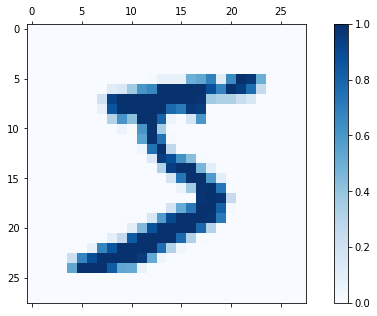

In [88]:
print('datapoint assigment to cluster with index =', int(y_train[0]))
plot_mat_(x_train[0].reshape(28,28), cmap='Blues')

In [ ]:
# can now start:

In [20]:
#from histograms import histogram_np_
def histogram_np_(x, x_range = None, n_bins=60, param=300, periodic=True):
        dim = x.shape[1]
        if dim > 1 and type(n_bins) is not list:
           n_bins = [n_bins]*dim
        else: pass
        hist = np.histogramdd(x, range=x_range, bins=n_bins)[0].astype(float)
        return hist / hist.sum()
    
#from utils import TIMER
import time
from IPython.display import clear_output
class TIMER:
    def __init__(self,
                 n_itter : int,
                 n_stars_show : int = 100,
                ):
        
        self.n_itter = n_itter
        self.loading_grid = np.linspace(0,n_itter-1,n_stars_show).astype(int)
        self.n_stars_show = n_stars_show
        self.it_was_zero = False
        self.t0 = time.time()
        
    def check_(self, it):
        if it in self.loading_grid:
            self.print_(it)
        else: pass
    
    def print_(self, it):
        self.refresh_loading_bar_(it)
        
    def refresh_loading_bar_(self, it):
        clear_output(wait=True)

        if it == 0: self.it_was_zero = True
        else: pass
        if self.it_was_zero is True: it += 1
        else: pass

        percent_completed = 100 * it / self.n_itter

        time_elapsed = time.time() - self.t0

        av_time_per_percent = time_elapsed / percent_completed

        expected_time_remaining = (100.0 - percent_completed)*time_elapsed / percent_completed

        #n_stars = self.n_stars ; n_spaces = self._n_stars_ - n_stars
        n_stars = int(percent_completed*self.n_stars_show/100.0) ;  n_spaces = self.n_stars_show - n_stars
        
        stars = ['*'*n_stars+'-'*n_spaces+' ']
        percent = [str(int(percent_completed)),'% ']
        time_taken = ['(time taken: ',str(round(time_elapsed, 3))+'s']
        av_time_step = ['' if av_time_per_percent is None else ' ['+str(round(av_time_per_percent, 3))+'s/%'+']']
        time_remaining = [')' if expected_time_remaining is None else ' ETA: '+str(round(expected_time_remaining, 3))+'s'+')']
    
        print(''.join(stars + percent))
        print(''.join(time_taken + av_time_step + time_remaining))

####

'''
S_ : Shannon entropy. Input: histogram.
I_ : Shannon information between marginals of 2D histogram. Input: 2D histogram. Ouput: float >= 0.0.
nI_ : normalised I_. Input: 2D histogram. Ouput: float in [0.0,1.0].
'''
S_ = lambda Px : - ( Px*np.ma.log(Px) ).sum()
I_ = lambda Pxy : ( Pxy*np.ma.log(np.ma.divide( Pxy, np.outer(Pxy.sum(1),Pxy.sum(0)) )) ).sum() # S_(Pxy.sum(1)) + S_(Pxy.sum(0)) - S_(Pxy)
# nI_ = lambda Pxy : I_(Pxy) / (S_(Pxy)+1e-10)
def nI_(Pxy):
    I = I_(Pxy)
    S = S_(Pxy)
    # I/S should be a float in range [0,1], but in MNIST dataset some inaccuracies due to round-off were seen, so:  
    if S <= 0.0:
        if I <= 0.0: return 0.0
        else: return 1.0
    else: return I/S

def PcSi_(c, X,
          i : int,
          S : list = [],
          x_range : list = [-np.pi,np.pi],
          n_bins : int = 20,
          shuffle_i : bool = False):
    ''' nD histogram (i).
    c : (N,) shaped array : categorical (numerical) variable. [axis=0 in output hist.]
    X : (N,d) shaped array with all elements in x_range.
    i : int (index) not found in S. [axis=-1 in output hist.]
    S : list of ints (indices [!=i]) for other columns in X. [if empty, output is 2D array.]
    x_range : list like [a,b]. All elements in X must be in range a <= x <= b.
    n_bins : number of histogram bins for X[:,i] and all X[:,j] for j in S.
    shuffle_i : bool whether to shuffle data in column X[:,i], before histogram. [Not used here.]
        [nTE was tested for this problem and works also indtead of mRMR, but having a hyperparameter (beta) is actually better.]

    Output: (len(set(c)),...,n_bins) shaped array, sums to 1 along any axes (histogram).
    '''
    N = c.shape[0]
    dim_X = len(S) + 1
    
    cSi = [c.reshape(N,1)]
    cSi += [X[:,j:j+1] for j in S]
    if shuffle_i: cSi += [X[np.random.choice(N, N,replace=False),i:i+1]]
    else:         cSi += [X[:,i:i+1]]
    cSi = np.concatenate(cSi, axis=1)

    x_range = [[c.min(),c.max()]] + [x_range]*dim_X
    n_bins = [c.max()-c.min()+1] + [n_bins]*dim_X

    return histogram_np_(cSi, x_range=x_range, n_bins=n_bins)

def PS_(X, S,
        x_range : list = [-np.pi,np.pi],
        n_bins : int = 20):
    ''' nD histogram (ii).
    X : (N,d) shaped array, with all elements in x_range.
    S : list of indices refering to columns in X.
    x_range : list like [a,b]. All elements in X must be in range a <= x <= b.
    n_bins : number of histogram bins for any X[:,j], where j in S.
    
    Output : (n_bins,n_bins) shaped array, sums to 1 along any axes (histogram).
    '''
    dim_X = len(S)
    
    S = [X[:,j:j+1] for j in S]
    S = np.concatenate(S, axis=1)
    x_range = [x_range]*dim_X
    n_bins = [n_bins]*dim_X
    
    return histogram_np_(S, x_range=x_range, n_bins=n_bins)

def mRMR_(c, X,
          Iic = None,
          Iij = None,
          dim_max : int = 3,
          x_range : list = [-np.pi,np.pi],
          n_bins : int = 20,
          beta : float = 1.0,
          verbose : bool = True):
    '''
    c : (N,) shaped array : (hard) cluster assigments (categorical variable).
    X : (N,d) shaped array, with all elements in x_range.
    Iic : (d,) shaped array or None (default).
        [Normalised MI matrix between features and c.]
    Iij : (d,d) shaped array or None (default).
        [Normalised MI matrix between pairs of features.]
    dim_max : int <= d.
    x_range : list [a,b] all elements in X must be in range a <= x <= b.
    n_bins : number of histogram bins for any column X[:,j].
    beta : float : hyperparameter for balance between Iic vs. Iij terms.
    verbose : bool : can be handy if d is high when first time running to get Iij (slowest part).
    '''
    dim = X.shape[1]
    set_X = np.arange(dim).tolist()
    
    if Iic is None:
        Iic = np.array([nI_(PcSi_(c=c, X=X, i=i, x_range=x_range, n_bins=n_bins)) for i in set_X])
    else: pass
    set_S = [np.argmax(Iic)]
    log = [Iic.max()] # [[set_X,Iic]]
    
    if Iij is None:
        if verbose: timer = TIMER(dim**2)
        else: pass
        a = 0
        Iij = np.eye(dim)*0.0
        for i in range(dim):
            for j in range(dim):
                if i >= j:
                    Iij[i,j] = Iij[j,i] = nI_(PS_(X, [i,j], x_range=x_range, n_bins=n_bins))
                else: pass
                a+=1
            if verbose: timer.print_(a)
            else: pass
    else: pass
    
    for _ in range(dim_max-1):
        f_list = []
        inds_search = list(set(set_X) - set(set_S))
        for i in inds_search:
            fi = Iic[i] - beta*Iij[i,set_S].mean()
            f_list.append(fi)
        
        set_S += [inds_search[np.argmax(f_list)]]
        log += [max(f_list)] # [[inds_search,f_list]]

    return np.array(set_S), np.array(log), Iic, Iij

# softmax_ = lambda x, axis=1, T=0.1 : np.exp(x/T) / np.exp(x/T).sum(axis=axis,keepdims=True)

cossin_ = lambda x : np.concatenate([np.cos(x),np.sin(x)], axis=1)

def selective_cossin_(X, periodic_mask):
    ''' X ~ (N,d)
        X ~ (N,n) ; n==d iff periodic_mask.sum() = 0.0, else n>d.
    '''
    X_out = []
    indexing_mask = []
    for i in range(X.shape[1]):
        if periodic_mask[i] == 1: 
            X_out.append(cossin_(X[:,i:i+1]))
            indexing_mask += [i,i]
        else: 
            X_out.append(X[:,i:i+1])
            indexing_mask += [i]
    return np.concatenate(X_out, axis=1), np.array(indexing_mask)

def selective_select_(X, set_S, indexing_mask):
    X_out = []
    for index in set_S:
        x = X[:,np.where(indexing_mask==index)[0]]
        X_out.append(x)
    return np.concatenate(X_out, axis=1)

def evaluate_linear_regression_(x_train, y_train, x_test):
    theta = np.linalg.pinv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
    y_test = x_test.dot(theta)
    return y_test

####

class FEATURE_RANKING:
    def __init__(self,
                 c, X,
                 X_periodic : np.ndarray or bool = True,
                 x_range : list = [-np.pi,np.pi],
                 n_bins : int = 20,
                ):
        '''
        c : (N,) shaped array : (hard) cluster assigments (categorical variable).
            [As usual with output of clustering algorithms: c[i] \in {0,..,K} forall i in range(N).]
        X : (N,d) shaped array, with all elements in x_range.
            [The columns are CVs (e.g., torsions) but can be evaluations of any bounded function.]
        X_periodic : bool or (N,) shaped np.ndarray with elements in {0,1}.
            [This is only relevant for the mRMR_autobeta_ function, where X is made euclidean.]
        x_range: list [a,b] all elements in X must be in range a <= x <= b, i.e., bounded.
        n_bins : number of histogram bins for any column X[:,j].
        '''

        self.N, self.dim = X.shape
        c = np.array(c).astype(int).reshape([self.N,])
        self.K = c.max()-c.min()+1

        if type(X_periodic) is bool and X_periodic: self.periodic_mask = np.ones([self.dim])
        elif type(X_periodic) == bool: self.periodic_mask = np.zeros([self.dim])
        else: self.periodic_mask = X_periodic

        self.x_range = x_range
        self.n_bins = n_bins

        self.c = c
        self.c_onehots = np.eye(self.K)[c]
        self.X = X
        self.X_for_auto, self.indexing_mask = selective_cossin_(X, self.periodic_mask)
        self.X_for_auto = np.concatenate([self.X_for_auto, np.ones([self.N,1])], axis=1)

        self.initialised = False

    def mRMR_(self,
              beta : float = 1.0,
              dim_max : int = None,
              verbose : bool = True):
        '''
        beta : float : the only actual hyperparameter. Default is 1.0 but this is unlikely best.
        dim_max : int in range [0,self.dim]
        verbose : The Iij matrix can take a while to make, loading bar displayed.
        
        Outputs:
            set_S : indices refer to columns of X. Indices are ordered in descending order of rank.
            log : some information which can be plotted. Scores.
        '''
        if dim_max is None or dim_max>self.dim: dim_max = self.dim
        else: pass

        if not self.initialised:
            set_S, log, Iic, Iij = mRMR_(self.c, self.X,
                                         Iic = None,
                                         Iij = None,
                                         dim_max = dim_max, x_range = self.x_range, n_bins = self.n_bins, beta = beta, verbose = verbose)
            self.Iic = Iic
            self.Iij = Iij
            self.initialised = True
            return set_S, log
        else:
            if verbose: print('Using stored Iic, Iij arrays, which were made using',self.n_bins,'bins.')
            else: pass
            set_S, log = mRMR_(self.c, self.X,
                               Iic = self.Iic,
                               Iij = self.Iij,
                               dim_max = dim_max, x_range = self.x_range, n_bins = self.n_bins, beta = beta, verbose = False)[:2]
            return set_S, log

    def mRMR_autobeta_(self,
                       grid_beta = np.linspace(0.2,8.0,20),
                       dim_max : int = None,
                       verbose : bool = True):
        '''
        grid_beta : uniform grid of trial floats, for grid search of beta automatically.
        dim_max : int in range [0,self.dim]. Best to set this to around self.dim//2.
        verbose : if True and self.dim very high, this is the loading bar.
        
        Outputs : 
            optimum_set_S_valid : the final answer, for best beta in grid.
            optimum_scoares_valid : coresponding scores for the indices of features in optimum_set_S_valid.
            
            # plotting error landscape: plt.plot(self._grid_beta,self._L)
                # if not convex enough can adjust dim_max, and run this function agian (it is fast at lower dim_max).
        '''
        
        if not self.initialised: self.mRMR_(beta=1.0, dim_max=1, verbose=verbose)
        else: pass

        if verbose: timer = TIMER(len(grid_beta))
        else: pass
        a = 0
        stack_set_S = []
        stack_log = []
        stack_norms = []
        if dim_max is None or dim_max>self.dim: dim_max = self.dim
        else: pass
        grid_dim_max = np.arange(1,dim_max+1)
        for i in range(len(grid_beta)):
            set_S, log = self.mRMR_(beta=grid_beta[i], dim_max=dim_max, verbose=False)[:2]
            stack_set_S.append(set_S)
            stack_log.append(log)

            norms = []
            for j in grid_dim_max:
                x_train = selective_select_(self.X_for_auto, set_S[:j], self.indexing_mask)
                y_hat = evaluate_linear_regression_(x_train = x_train,
                                                    y_train = self.c_onehots,
                                                    x_test = x_train)
                norms.append(np.linalg.norm(self.c_onehots - y_hat))

            stack_norms.append(norms)
            a+=1
            if verbose: timer.print_(a)
            else: pass
        
        L = np.array(stack_norms).mean(1)
        index_beta_grid_optimum = np.argmin(L)
        optimum_beta = np.array(grid_beta)[index_beta_grid_optimum]
        optimum_set_S = np.array(stack_set_S[index_beta_grid_optimum])
        optimum_scoares = np.array(stack_log[index_beta_grid_optimum])
        inds_valid = np.where(optimum_scoares>0.0)[0] # on mnist this thereshold removes spurious result.
        optimum_set_S_valid = optimum_set_S[inds_valid]
        optimum_scoares_valid = optimum_scoares[inds_valid]
            
        if verbose:
            print('optimum beta (from grid_beta provided) is:', optimum_beta)
            print('returning array of indices of features in order of decreasing score.')
            print('returning array of scores for these indices.')
        else: pass
        
        # not returned but just in case stored:
        #
        self._grid_beta = np.array(grid_beta)
        self._L = L
        self._index_beta_grid_optimum = index_beta_grid_optimum
        self._optimum_beta = optimum_beta
        self._optimum_set_S = optimum_set_S
        self._optimum_scoares = optimum_scoares
        self._inds_valid = inds_valid
        self._optimum_set_S_valid = optimum_set_S_valid
        self._optimum_scoares_valid = optimum_scoares_valid
        ##
        self._stack_norms = stack_norms
        self._stack_set_S = stack_set_S
        self._stack_log = stack_log
        
        return optimum_set_S_valid, optimum_scoares_valid
        

In [9]:
#X_periodic = np.where(np.random.randn(784)>0.0,1,0)
#x_train = x_train*np.pi*2
#x_range = [0.,np.pi*2]

In [22]:
f_r = FEATURE_RANKING(c=y_train, X=x_train, X_periodic=False, x_range=[0.0,1.0], n_bins=20)
#f_r.X_for_auto.shape

In [23]:
'''
f_r.Iic = Iic_bu
f_r.Iij = Iij_bu
f_r.initialised = True
'''

In [11]:
set_S, log = f_r.mRMR_(beta=1.0, dim_max=5, verbose=True)
set_S

**************************************************************************************************** 100% 
(time taken: 410.666s [4.107s/%] ETA: 0.0s)


[378, 567, 461, 409, 155]

In [71]:
set_S, log = f_r.mRMR_(beta=1.0, dim_max=None, verbose=True)
set_S[:10]

Using stored Iic, Iij arrays, which were made using 20 bins.


array([378, 567, 461, 409, 155, 428, 542, 290, 406, 374])

In [25]:
# Both of these can take a while to compute for large datasets, but this is a one-time cost.
# Around n_bin=20 in both cases worked alright here.
# They were backed up here in case f_r needs reinitialising:

Iic_bu = np.array(f_r.Iic) # normalised mutual information (MI) array between features and cluster assigments.
Iij_bu = np.array(f_r.Iij) # normalised mutual information (MI) matrix between pairs of features.

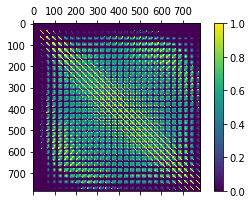

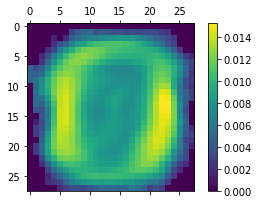

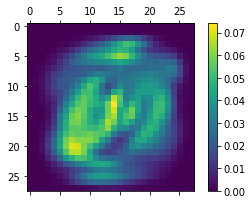

In [93]:
# normalised MI matrix between pairs of features:
plot_mat_(1-np.exp(-f_r.Iij/0.01), figsize=(5,3)) # 0.003
# normalised MI between pairs of features is actually not enough to trivially find good features:
plot_mat_(f_r.Iij.mean(0).reshape(28,28), figsize=(5,3))
# normalised MI array between features and cluster assigments, has more information: [fsdp can be used on top 20 or so pca dims.]
plot_mat_(f_r.Iic.reshape(28,28), figsize=(5,3))

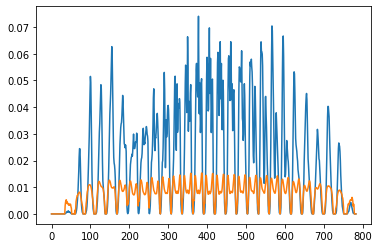

In [27]:
plt.plot(f_r.Iic)
plt.plot(f_r.Iij.mean(0))

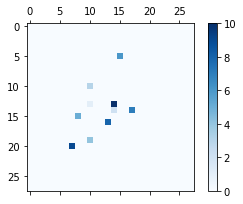

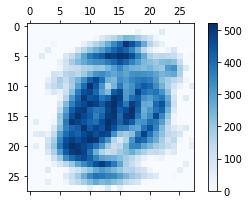

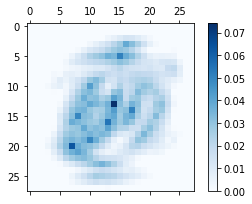

In [72]:
n_show = 10

inds_valid = np.where(log>0.0)[0]

check = np.zeros((784))
check[set_S[inds_valid[:n_show]]] = n_show - np.arange(n_show)
plot_mat_(check.reshape(28,28), figsize=(5,3), cmap='Blues') 

##

inds_valid = np.where(log>0.00)[0]

n_show = len(inds_valid)

check = np.zeros((784))
check[set_S[inds_valid[:n_show]]] = n_show - np.arange(n_show)
plot_mat_(check.reshape(28,28), figsize=(5,3), cmap='Blues') 

check = np.zeros((784))
check[set_S[inds_valid[:n_show]]] = log[inds_valid[:n_show]]
# Centroids of f_r.Iic.reshape(28,28) get the highest scores.
# We can reduce temperature to by incresing beta (to >1.0 here), to increase number of useful features found.
plot_mat_(check.reshape(28,28), figsize=(5,3), cmap='Blues')

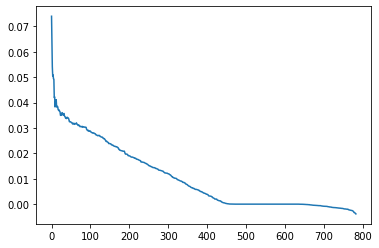

In [38]:
plt.plot(log)

With automatic search of the hyperparameter:

In [39]:
grid_beta = np.linspace(0.2,8.0,20)

In [41]:
optimum_set_S_valid, optimum_scoares_valid = f_r.mRMR_autobeta_(grid_beta = grid_beta,
                                                                dim_max = 100,
                                                                verbose = True)

**************************************************************************************************** 100% 
(time taken: 122.42s [1.224s/%] ETA: 0.0s)
optimum beta (from grid_beta provided) is: 3.073684210526316
returning array of indices of features in order of decreasing score.
returning array of scores for these indices.


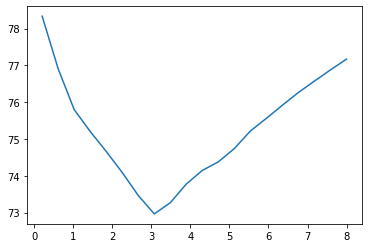

In [76]:
plt.plot(f_r._grid_beta,f_r._L) # in that set of top 100 features (can be less) the best ranking was when beta is 3.07 here.

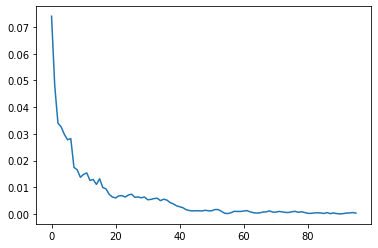

In [89]:
plt.plot(optimum_scoares_valid) # these dont reach zero, so Iic was definitely non-zero for these features, which is important.
# optimum_set_S_valid is the final result of this notebook.

In [67]:
# it is cheap to run GFS one more time with new beta.
set_S, log = f_r.mRMR_(beta=f_r._optimum_beta, dim_max=None, verbose=True)
set_S[:10]

Using stored Iic, Iij arrays, which were made using 20 bins.


array([378, 567, 514, 409, 461, 401, 155, 290, 655, 375])

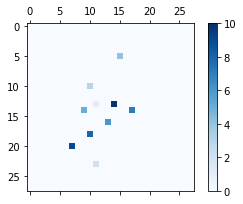

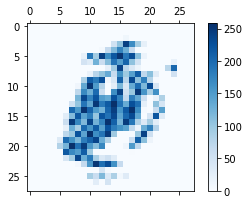

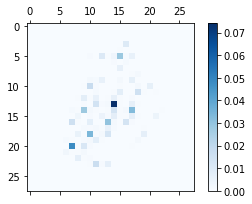

In [69]:
n_show = 10

inds_valid = np.where(log>0.0)[0]

check = np.zeros((784))
check[set_S[inds_valid[:n_show]]] = n_show - np.arange(n_show)
# top 10 features are now a bit better spread out (more orthogonal).
plot_mat_(check.reshape(28,28), figsize=(5,3), cmap='Blues') 
##

inds_valid = np.where(log>0.00)[0]

n_show = len(inds_valid)

check = np.zeros((784))
check[set_S[inds_valid[:n_show]]] = n_show - np.arange(n_show)
plot_mat_(check.reshape(28,28), figsize=(5,3), cmap='Blues') 

check = np.zeros((784))
check[set_S[inds_valid[:n_show]]] = log[inds_valid[:n_show]]
plot_mat_(check.reshape(28,28), figsize=(5,3), cmap='Blues') 

best line has lowest error at any choice of dim_max, here at beta ~= 3.074


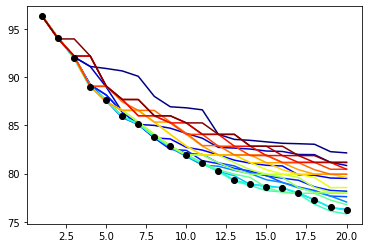

In [75]:
# very red or very blue (edges of the beta grid) are pool solutions, optimum found:

colors = plt.cm.jet(np.linspace(0,1,len(f_r._grid_beta)))
n_show = 20

[plt.plot(np.arange(1,n_show+1),f_r._stack_norms[i][:n_show], color=colors[i], alpha=1) for i in range(len(f_r._grid_beta))]

plt.plot(np.arange(1,n_show+1),f_r._stack_norms[f_r._index_beta_grid_optimum][:n_show],'o',color='black')

print('best line has lowest error at any choice of dim_max, here at beta ~=',f_r._optimum_beta.round(3))

In [ ]:
# cut-off needed for keeping only the features which have >0 score:

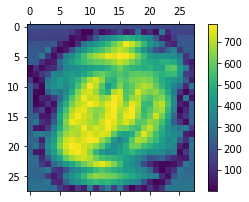

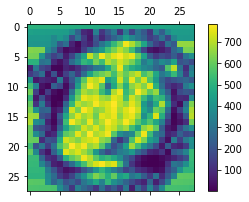

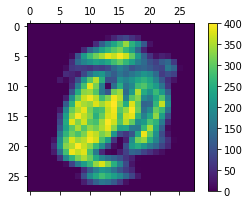

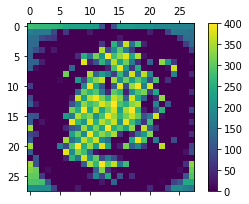